In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

In [2]:
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime


is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

initialize:  True
logged in:  True


2023-04-19 14:04:56.526211 | Login:  114123121 | Balance:  515.32 | Equity:  512.72


In [3]:
symbol = 'XAUUSD'
number_of_date= 10000
timeframe = mt5.TIMEFRAME_H1
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df[['date','open','high','low','close','volume']]
df = df.set_index("date")
print(df.head()) # just to make sure that sorted from old to new

                         open      high       low     close  volume
date                                                               
2021-08-09 16:00:00  1728.414  1728.531  1723.846  1726.143    5785
2021-08-09 17:00:00  1726.175  1729.899  1724.650  1729.899    4352
2021-08-09 18:00:00  1729.868  1731.698  1728.056  1728.323    3295
2021-08-09 19:00:00  1728.357  1730.655  1728.351  1728.749    3228
2021-08-09 20:00:00  1728.718  1730.628  1728.492  1729.573    1752


##### Adding Features

In [4]:
df['RSI'] = ta.rsi(df.close, length = 15)
df['EMAF'] = ta.ema(df.close, length = 20)
df['EMAM'] = ta.ema(df.close, length = 100)
df['EMAS'] = ta.ema(df.close, length = 150)
# df['Target'] = df['close'] - df.open
# df['Target'] = df['Target'].shift(-1)

# df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['Target-Next-Close'] = df['close'].shift(-1)



df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['date','volume'], axis=1 , inplace=True)
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target-Next-Close
0,1791.215,1792.283,1789.699,1790.230,58.957674,1787.361089,1771.268623,1759.171827,1789.424
1,1790.183,1790.404,1788.731,1789.424,56.769136,1787.557556,1771.628135,1759.572518,1790.626
2,1789.378,1790.822,1787.889,1790.626,59.189698,1787.849789,1772.004331,1759.983822,1791.691
3,1790.673,1793.261,1790.167,1791.691,61.249420,1788.215619,1772.394166,1760.403785,1790.171
4,1791.694,1793.741,1790.049,1790.171,56.860977,1788.401845,1772.746182,1760.798052,1787.796
...,...,...,...,...,...,...,...,...,...
9845,2003.460,2006.888,2001.936,2004.189,50.637146,2003.999043,2007.940411,2007.549741,2003.397
9846,2004.172,2004.769,2002.175,2003.397,49.238163,2003.941706,2007.850442,2007.494738,2003.909
9847,2003.431,2004.442,2002.587,2003.909,50.191302,2003.938591,2007.772394,2007.447244,2000.439
9848,2003.928,2004.279,1999.470,2000.439,44.169041,2003.605296,2007.627178,2007.354420,1991.049


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range=(0,1))
# data_set_scaled = sc.fit_transform(df)
# data_set_scaled

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_set_scaled = sc.fit_transform(df)
data_set_scaled[:,8]


array([-0.32696095, -0.31322853, -0.30106128, ...,  2.08381062,
        1.9765332 ,  1.98904319])

In [6]:
X = []
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

9850


In [7]:
X=np.moveaxis(X, [0], [2])
X.shape

(9820, 30, 8)

In [11]:
X = np.array(X)
y = np.array(data_set_scaled[backcandles:,-1])
# y = np.reshape(y,(len(y),1))
print(X.shape) # 3D X has 8 colume and each colume contain xx backcandles (row, backcandle, column)
print(y.shape) # 2D contain 1 value (it's 1D array that reshape into 2D array)
print(y[0:10])

(9820, 30, 8)
(9820,)
[-0.35572821 -0.33316454 -0.38713456 -0.42740644 -0.39827359 -0.40427153
 -0.4245617  -0.43340437 -0.42266521 -0.43664897]


In [19]:
proportion = int(len(X)*0.8)
X_train, X_test = X[:proportion],X[proportion:]
y_train, y_test = y[:proportion],y[proportion:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X[1,1:10,1])

(7856, 30, 8)
(7856,)
(1964, 30, 8)
(1964,)
[-0.33574245 -0.3079471  -0.30247692 -0.34197617 -0.35820437 -0.36002776
 -0.37428442 -0.33112698 -0.33839776]


In [20]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation
from keras import optimizers
from keras.callbacks import History
import tensorflow as tf

lstm_input = Input(shape=(backcandles, 8), name = 'lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs = lstm_input, outputs = output)
adam = optimizers.Adam()
model.compile(optimizer=adam,loss='mse')
model.fit(x=X_train, y = y_train, batch_size=15, epochs=30, shuffle=True,validation_data=(X_test, y_test))

Epoch 1/30
524/524 [==============================] - 5s 8ms/step - loss: 0.0094 - val_loss: 0.0117
Epoch 2/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 3/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 4/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 5/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 6/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 7/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 8/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 9/30
524/524 [==============================] - 4s 8ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 10/30
524/524 [==============================] - 4s 9ms/step - loss: 0.0034 - val_loss: 0.0038

In [21]:
y_hat = model.predict(X_test)

62/62 [==============================] - 0s 4ms/step


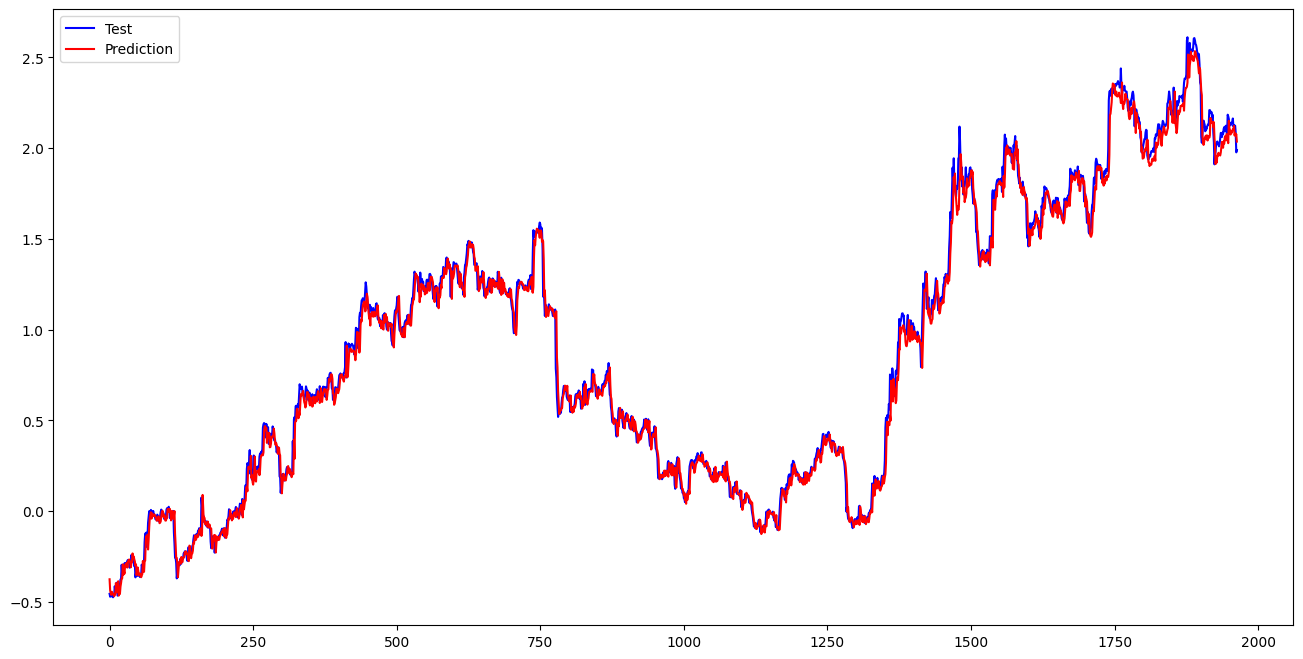

In [22]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_hat, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# Define the input layer with shape (backcandles, 8)
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')

# Add a LSTM layer with 150 units
lstm_layer = LSTM(units=150, name='lstm_layer')(lstm_input)

# Add a dense layer with a single output neuron
dense_layer = Dense(units=1, name='dense_layer')(lstm_layer)

# Add an activation layer with a linear activation function
output = Activation('linear', name='output')(dense_layer)

# Build the model
model = Model(inputs=lstm_input, outputs=output)

# Compile the model with the Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data with a batch size of 15 and for 30 epochs
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_data=(X_test, y_test))


In [ ]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)


In [ ]:
# Generate predictions on the test data
y_pred = model.predict(X_test)

# Compute the accuracy
accuracy = (y_pred == y_test).mean()

# Compute the precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

# Print the performance metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
